# Fine-Tuning A Foundation Model For Naturalness Prediction

This notebook demonstrates how to fine-tune a foundation cheminform model using the ChEMBL data with naturalness annotation.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from scripts.gen_train_test import prepare_data
from scripts.helper import get_tokenize_func

# Disable Weights & Biases logging
os.environ['WANDB_DISABLED'] = 'true'

In [2]:
train_data_path='../data/train_data.tsv'
test_data_path='../data/test_data.tsv'

# Generate train_data.tsv and test_data.tsv if they do not exist
if not os.path.exists(train_data_path) or not os.path.exists(test_data_path):
    train_data, test_data = prepare_data('../data/marked_ChEMBL_small_molecules.tsv.gz', train_data_path, test_data_path)
else:
    train_data = pd.read_csv(train_data_path, sep='\t')
    test_data = pd.read_csv(test_data_path, sep='\t')

# Convert to Dataset
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

In [3]:
# Load model and tokenizer

model_checkpoint = "seyonec/SMILES_tokenized_PubChem_shard00_160k"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenize_func = get_tokenize_func(tokenizer)

# Tokenize datasets
tokenized_train_datasets = train_dataset.map(tokenize_func, batched=True)
tokenized_test_datasets = test_dataset.map(tokenize_func, batched=True)

# Initialize model
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Map:   0%|          | 0/10596 [00:00<?, ? examples/s]

Map:   0%|          | 0/2649 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/SMILES_tokenized_PubChem_shard00_160k and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
)

# Initialize the Trainer
# Split the tokenized training dataset into training and validation subsets
train_val_split = tokenized_train_datasets.train_test_split(test_size=0.2, seed=42)
train_subset = train_val_split['train']
val_subset = train_val_split['test']

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=val_subset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

# Train the model
trainer.train()

# Save the fine-tuned model
trainer.save_model('fine_tuned_model')

/home/shuli/miniconda3/envs/torch/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.478030,0.921226
2,0.023600,0.395624,0.930660
3,0.023600,0.356504,0.932547


In [12]:
# Load the fine-tuned model
loaded_model = AutoModelForSequenceClassification.from_pretrained('fine_tuned_model')

# Initialize a new Trainer with the loaded model
trainer = Trainer(
    model=loaded_model
)

tokenized_test_datasets = test_dataset.map(tokenize_func, batched=True)
# Predict on the test dataset
predictions = trainer.predict(test_dataset=tokenized_test_datasets)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Calculate and print accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy on test dataset: {accuracy:.4f}")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/2649 [00:00<?, ? examples/s]

Accuracy on test dataset: 0.9324


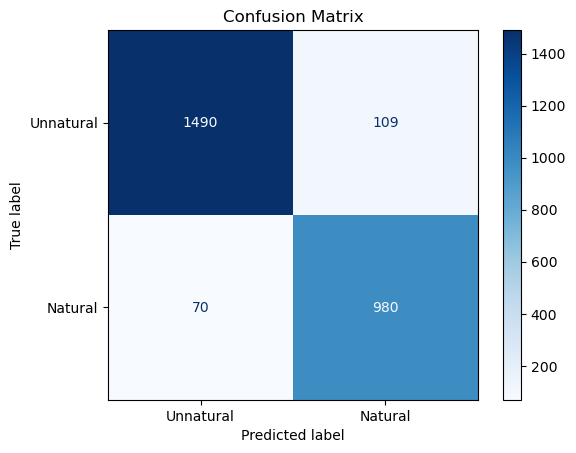

In [13]:
# Visualize the predictions with a confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Unnatural', 'Natural'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()